# Log file to deviation curve, in Java

In [1]:
// Requires  ../../gradlew shadowJar from the NMEA-Parser folder
%classpath add jar "../../../NMEA-Parser/build/libs/NMEA-Parser-1.0-all.jar"
// Requires ../gradlew build from the common-utils folder
%classpath add jar "../../../../common-utils/build/libs/common-utils-1.0.jar"
// For the graphics at the end
// Needs to be published in the maven local.    
// Requires a "../gradlew publishToMavenLocal" from the repo at https://github.com/OlivierLD/raspberry-coffee/tree/master/Algebra
%maven oliv.raspi.coffee:Algebra:1.0

The generic shape of a deviation curve is
$$
dev(r) = a + (b \times \sin r) + (c \times \cos r) + (d \times \sin 2r) + (e \times \cos 2r)
$$

We want to solve the following system

$$

\begin{vmatrix} a & b & c & d & e \end{vmatrix} 
=
\begin{vmatrix}
  &n  &\sum_{i=0}^{n}\sin(r)  &\sum_{i=0}^{n}\cos(r)  &\sum_{i=0}^{n}\sin(2r)  &\sum_{i=0}^{n}\cos(2r) \\
  &\sum_{i=0}^{n}\sin(r)  &\sum_{i=0}^{n}\sin(r)^2  &\sum_{i=0}^{n}\sin(r)cos(r)  &\sum_{i=0}^{n}\sin(2r)sin(r))  &\sum_{i=0}^{n}\cos(2r)sin(r) \\
  &\sum_{i=0}^{n}\cos(r)  &\sum_{i=0}^{n}\cos(r)sin(r)  &\sum_{i=0}^{n}\cos(r)^2  & \sum_{i=0}^{n}\sin(2r)cos(r) &\sum_{i=0}^{n}\cos(2r)cos(r) \\
  &\sum_{i=0}^{n}\sin(2r)  &\sum_{i=0}^{n}\sin(2r)sin(r)  &\sum_{i=0}^{n}\sin(2r)cos(r)  &\sum_{i=0}^{n}\sin(2r)^2  &\sum_{i=0}^{n}\cos(2r)sin(2r) \\
  &\sum_{i=0}^{n}\cos(2r)  &\sum_{i=0}^{n}\cos(2r)sin(r)  &\sum_{i=0}^{n}\cos(2r)cos(r)  &\sum_{i=0}^{n}\cos(2r)sin(2r)  &\sum_{i=0}^{n}\cos(2r)^2
 \end{vmatrix}^{-1}
\times
\begin{vmatrix}
  &\sum_{i=0}^{n}\ dev \\
  &\sum_{i=0}^{n}\ dev.sin(r) \\
  &\sum_{i=0}^{n}\ dev.cos(r) \\
  &\sum_{i=0}^{n}\ dev.sin(2r) \\
  &\sum_{i=0}^{n}\ dev.cos(2r)
 \end{vmatrix}

 $$


## Step 1
The first step is to turn the log file content into a usable cloud of points.  
Points will be defined by
- the heading
- the corresponding deviation
We will be using the `HDG` and `RMC` NMEA Strings.  
The default declination will be hard-coded to 14E, aka +14.

In [2]:
import java.io.File;
import java.io.FileReader;
import java.io.BufferedReader;
import nmea.parser.HDG;
import nmea.parser.RMC;
import nmea.parser.StringParsers;
import calc.GeomUtil;

In [3]:
// System.out.printf("Current directory :%s\n", System.getProperty("user.dir"));
// System.out.printf("GridSquare test:%s\n", GeomUtil.gridSquare(47.677667, -3.135667));

File logFile = null;
try {
    logFile = new File("../2010-11-03.Taiohae.nmea");
    if (logFile.exists()) {
        System.out.println("Log file was found.");
    } else {
        System.out.println("Oops, Log file was NOT found...");
    }
} catch (Exception ex) {
    ex.printStackTrace();
}

Log file was found.


In [4]:
long nbRec = 0;
double decl = 14d; // This must match the logging situation, if not in HDG or RMC

private static class LoggedPoint {
  double hdm;
  double dev;
  
  public LoggedPoint(double hdm, double dev) {
      this.hdm = hdm;
      this.dev = dev;
  }
  
  public double getDev() {
      return this.dev;
  }
  public double getHdm() {
      return this.hdm;
  }
}

List<LoggedPoint> pointCloud = new ArrayList<>();

double standingHDM = -Double.MAX_VALUE;
double standingCOG = -Double.MAX_VALUE;

boolean boatIsMoving = false;

BufferedReader br = new BufferedReader(new FileReader(logFile));
String line = "";
while (line != null) {
    line = br.readLine();
    if (line != null) {
        if (line.startsWith("$") && line.length() > 6) {
            StringParsers.ParsedData parsedData = StringParsers.autoParse(line);
            if ("HDG".equals(parsedData.getSentenceId())) {
                HDG heading = (HDG) parsedData.getParsedData();
                double hdg = heading.getHeading();
                double hdm = hdg;
                if (heading.getVariation() != -Double.MAX_VALUE) {
                    decl = heading.getVariation();
                    // System.out.printf("HDG Decl: %f\n", decl);
                }
                if (decl != -Double.MAX_VALUE) {
                    hdm += decl;
                }
                standingHDM = hdm;
            } else if ("RMC".equals(parsedData.getSentenceId())) {
                RMC rmc = (RMC)parsedData.getParsedData();
                double cog = rmc.getCog();
                double rmcDecl = rmc.getDeclination();
                if (rmcDecl != -Double.MAX_VALUE) {
                    decl = rmcDecl;
                    // System.out.printf("RMC Decl: %f\n", decl);
                }
                standingCOG = cog;
                double sog = rmc.getSog();
                boatIsMoving = (sog > 0);
            }
        }
        if (boatIsMoving && standingCOG != -Double.MAX_VALUE && standingHDM != -Double.MAX_VALUE) {
            double dev = standingHDM - standingCOG;
            while (dev > 180) {
                dev -= 360;
            }
            while (dev < -180) {
                dev += 360;
            }
            // System.out.printf("%s{ \"hdm\": %f, \"dev\": %f }\n", (nbRec > 0 ? "," : ""), standingHDM, dev);
            pointCloud.add(new LoggedPoint(standingHDM, dev));
            
            standingCOG = -Double.MAX_VALUE;
            standingHDM = -Double.MAX_VALUE;
            nbRec++;
        }
    }
}
System.out.printf("Generated a in-memory cloud of %d points (%d).\n", nbRec, pointCloud.size());


Generated a in-memory cloud of 729 points (729).


java.io.PrintStream@4e1f2e04

## Step 2
Compose the system elements

In [5]:
int dimension = 5;
double maxDev = 20d; // Do not use point if abs(dev) > maxDev

// The sum holders
double n = 0, sinR = 0, cosR = 0, sin2R = 0, cos2R = 0,
       sinR2 = 0, sinRcosR = 0, sin2RsinR = 0, cos2RsinR = 0,
       cosR2 = 0, sin2RcosR = 0, cos2RcosR = 0, sin2R2 = 0,
       cos2Rsin2R = 0, cos2R2 = 0;
double d = 0, dSinR = 0, dCosR = 0, dSin2R = 0, dCos2R = 0;

In [6]:
pointCloud.stream()
          .filter(pt -> Math.abs(pt.dev) < maxDev)
          .forEach(point -> {
    n += 1;
    sinR += Math.sin(Math.toRadians(point.hdm));
    cosR += Math.cos(Math.toRadians(point.hdm));
    sin2R += Math.sin(2 * Math.toRadians(point.hdm));
    cos2R += Math.cos(2 * Math.toRadians(point.hdm));
    sinR2 += Math.pow(Math.sin(Math.toRadians(point.hdm)), 2);
    sinRcosR += (Math.sin(Math.toRadians(point.hdm)) * Math.cos(Math.toRadians(point.hdm)));
    sin2RsinR += (Math.sin(2 * Math.toRadians(point.hdm)) * Math.sin(Math.toRadians(point.hdm)));
    cos2RsinR += (Math.cos(2 * Math.toRadians(point.hdm)) * Math.sin(Math.toRadians(point.hdm)));
    cosR2 += Math.pow(Math.cos(Math.toRadians(point.hdm)), 2);
    sin2RcosR += (Math.sin(2 * Math.toRadians(point.hdm)) * Math.cos(Math.toRadians(point.hdm)));
    cos2RcosR += (Math.cos(2 * Math.toRadians(point.hdm)) * Math.cos(Math.toRadians(point.hdm)));
    sin2R2 += Math.pow(Math.sin(2 * Math.toRadians(point.hdm)), 2);
    cos2Rsin2R += (Math.cos(2 * Math.toRadians(point.hdm)) * Math.sin(2 * Math.toRadians(point.hdm)));
    cos2R2 += Math.pow(Math.cos(2 * Math.toRadians(point.hdm)), 2);

    d += point.dev;
    dSinR += (point.dev * Math.sin(Math.toRadians(point.hdm)));
    dCosR += (point.dev * Math.cos(Math.toRadians(point.hdm)));
    dSin2R += (point.dev * Math.sin(2 * Math.toRadians(point.hdm)));
    dCos2R += (point.dev * Math.cos(2 * Math.toRadians(point.hdm)));
});

In [7]:
import algebra.SquareMatrix;
import algebra.SystemUtil;

In [8]:
SquareMatrix squareMatrix = new SquareMatrix(dimension);

In [9]:
/* Populate the square matrix */
// Line 1
squareMatrix.setElementAt(0, 0, n);
squareMatrix.setElementAt(0, 1, sinR);
squareMatrix.setElementAt(0, 2, cosR);
squareMatrix.setElementAt(0, 3, sin2R);
squareMatrix.setElementAt(0, 4, cos2R);
// Line 2
squareMatrix.setElementAt(1, 0, sinR);
squareMatrix.setElementAt(1, 1, sinR2);
squareMatrix.setElementAt(1, 2, sinRcosR);
squareMatrix.setElementAt(1, 3, sin2RsinR);
squareMatrix.setElementAt(1, 4, cos2RsinR);
// Line 3
squareMatrix.setElementAt(2, 0, cosR);
squareMatrix.setElementAt(2, 1, sinRcosR);
squareMatrix.setElementAt(2, 2, cosR2);
squareMatrix.setElementAt(2, 3, sin2RcosR);
squareMatrix.setElementAt(2, 4, cos2RcosR);
// Line 4
squareMatrix.setElementAt(3, 0, sin2R);
squareMatrix.setElementAt(3, 1, sin2RsinR);
squareMatrix.setElementAt(3, 2, sin2RcosR);
squareMatrix.setElementAt(3, 3, sin2R2);
squareMatrix.setElementAt(3, 4, cos2Rsin2R);
// Line 5
squareMatrix.setElementAt(4, 0, cos2R);
squareMatrix.setElementAt(4, 1, cos2RsinR);
squareMatrix.setElementAt(4, 2, cos2RcosR);
squareMatrix.setElementAt(4, 3, cos2Rsin2R);
squareMatrix.setElementAt(4, 4, cos2R2);

In [10]:
/* Populate the column matrix */
double[] constants = new double[dimension];
constants[0] = d;
constants[1] = dSinR;
constants[2] = dCosR;
constants[3] = dSin2R;
constants[4] = dCos2R;

642.484070655878

## Step 3 - Solve the system

In [11]:
// Solve the system
double[] coeffs = SystemUtil.solveSystem(squareMatrix, constants);
System.out.printf("Calculated %d coefficients.\n", coeffs.length)

Calculated 5 coefficients.


java.io.PrintStream@4e1f2e04

In [12]:
// Display coefficients
System.out.printf("Coeff a: %f\n", coeffs[0]);
System.out.printf("Coeff b: %f\n", coeffs[1]);
System.out.printf("Coeff c: %f\n", coeffs[2]);
System.out.printf("Coeff d: %f\n", coeffs[3]);
System.out.printf("Coeff e: %f\n", coeffs[4]);


Coeff a: -3.087894
Coeff b: 5.925650
Coeff c: -0.726193
Coeff d: 3.947782
Coeff e: -0.556099


java.io.PrintStream@4e1f2e04

## Step 4 - Optional Graphics

In [13]:
import gsg.SwingUtils.WhiteBoardPanel;
import gsg.VectorUtils;
import java.util.concurrent.atomic.AtomicInteger;
import java.awt.Color;
import java.awt.Dimension;
import java.awt.Font;

In [14]:
WhiteBoardPanel whiteBoard = new WhiteBoardPanel();
whiteBoard.setAxisColor(new Color(125, 0, 255, 255));
whiteBoard.setWithGrid(true);
whiteBoard.setBgColor(new Color(250, 250, 250, 255));
whiteBoard.setGraphicTitle("Dev Curve");
whiteBoard.setSize(new Dimension(800, 600));
whiteBoard.setTextColor(Color.RED);
whiteBoard.setTitleFont(new Font("Arial", Font.BOLD | Font.ITALIC, 32));
whiteBoard.setGraphicMargins(30);
whiteBoard.setXEqualsY(false);

In [15]:
List<VectorUtils.Vector2D> cloudVectors = new ArrayList<>();

In [16]:
System.out.println(String.format("We have %d points in the cloud of points.", pointCloud.size()));
pointCloud.stream()
          .filter(pt -> Math.abs(pt.dev) < maxDev)
          .forEach(point -> {
    cloudVectors.add(new VectorUtils.Vector2D(point.getHdm(), point.getDev()));
});

We have 729 points in the cloud of points.


Add the cloud of points to the Graphic

In [17]:
WhiteBoardPanel.DataSerie pointSerie = new WhiteBoardPanel.DataSerie()
                            .data(cloudVectors)
                            .graphicType(WhiteBoardPanel.GraphicType.POINTS)
                            .circleDiam(6)
                            .color(Color.BLUE);
whiteBoard.addSerie(pointSerie);

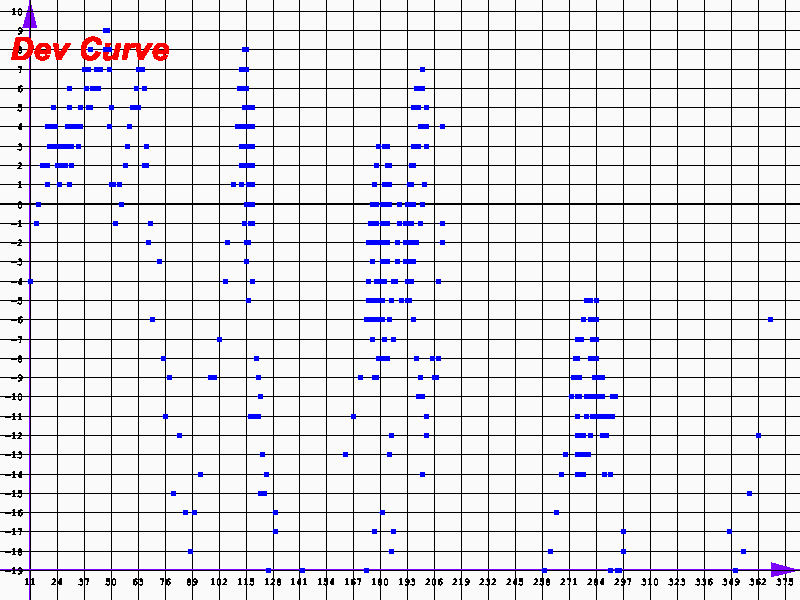

In [18]:
whiteBoard.getImage(); // This is for a Notebook

Draw the curve and add it to the Graphic.

Reminder: The generic shape of a deviation curve is
$$
dev = a + (b \times \sin r) + (c \times \cos r) + (d \times \sin 2r) + (e \times \cos 2r)
$$

In [19]:
import java.util.function.Function;

Function<Double, Double> devCurveFunction = (heading) -> {
    return coeffs[0] + 
          (coeffs[1] * Math.sin(Math.toRadians(heading))) +
          (coeffs[2] * Math.cos(Math.toRadians(heading))) +
          (coeffs[3] * Math.sin(2 * Math.toRadians(heading))) +
          (coeffs[4] * Math.cos(2 * Math.toRadians(heading)));
};

In [20]:
List<VectorUtils.Vector2D> function = new ArrayList<>();

In [21]:
for (double x=0d; x<360d; x+=1) {
    function.add(new VectorUtils.Vector2D(x, devCurveFunction.apply(x)));
}

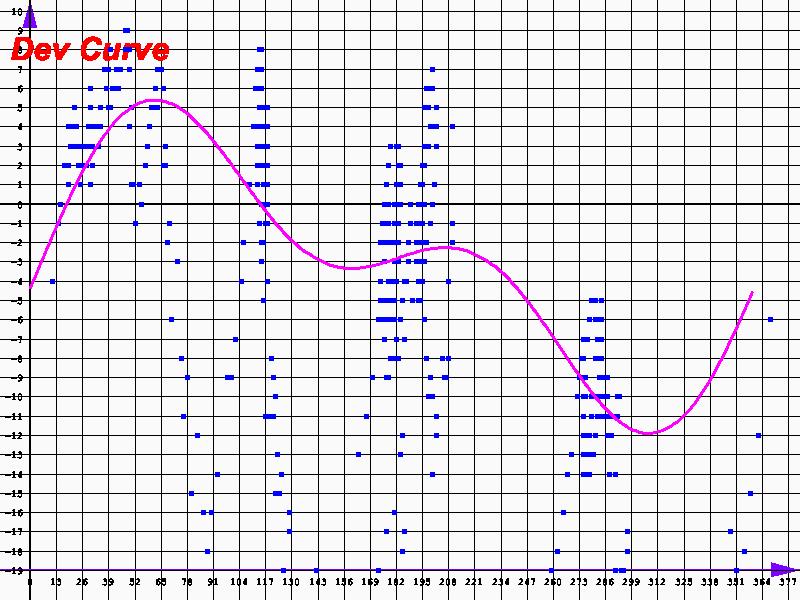

In [22]:
WhiteBoardPanel.DataSerie functionSerie = new WhiteBoardPanel.DataSerie()
                            .data(function)
                            .graphicType(WhiteBoardPanel.GraphicType.LINE)
                            .lineThickness(3)
                            .color(Color.MAGENTA);
whiteBoard.addSerie(functionSerie);

whiteBoard.getImage(); // Display whiteboard in a Notebook